In [1]:
#import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import geoplot as gplt
import geopandas as gpd
from shapely.geometry import Point

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('cleaned_data_final.csv')
len(df)

535

In [3]:
df['State2']

0             Texas
1        New Jersey
2      South Dakota
3          Colorado
4          Michigan
           ...     
530    Pennsylvania
531      California
532       Tennessee
533        Michigan
534           Texas
Name: State2, Length: 535, dtype: object

## Age and Gender plot

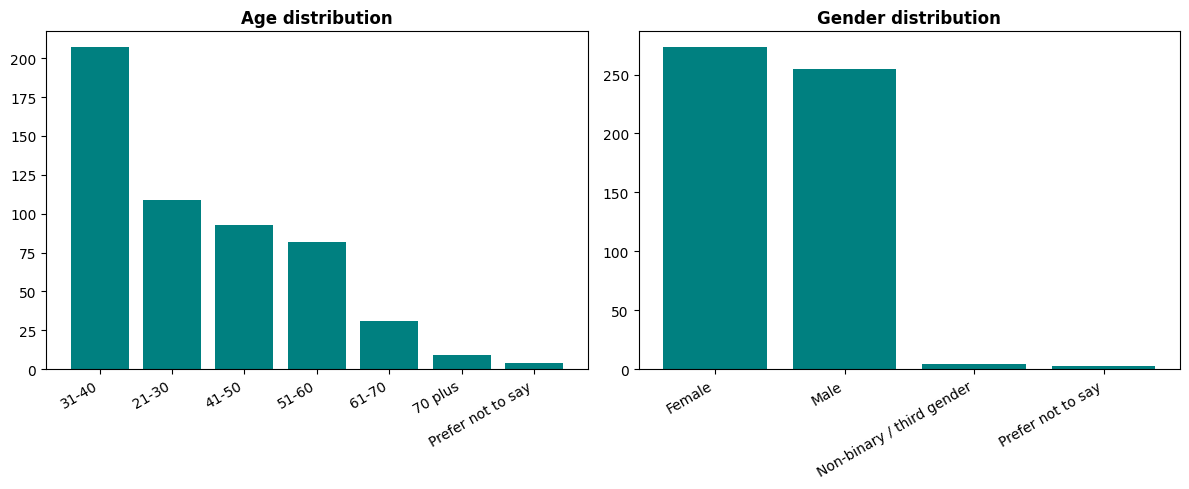

In [4]:
age_counts = df['Age'].value_counts().reset_index()
age_counts.columns = ['Age', 'count']
gender_counts = df['Gender'].value_counts().reset_index()
gender_counts.columns = ['Gender', 'count']

# Create figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plotting Age in first subplot
ax1.bar(age_counts['Age'], age_counts['count'] , color='teal')
ax1.set_title('Age distribution', fontweight='bold')

# Plotting Gender in second subplot
ax2.bar(gender_counts['Gender'], gender_counts['count'], color='teal')
ax2.set_title('Gender distribution',fontweight='bold')
plt.gcf().autofmt_xdate()
plt.tight_layout()

## Participants Distribution across U.S.

In [5]:
# Get the file path for the "contiguous_usa" dataset
path = gplt.datasets.get_path("contiguous_usa")
# Read the shapefile from the given path into a GeoDataFrame
contiguous_usa = gpd.read_file(path)

In [6]:
# Read the shapefile for US states into a GeoDataFrame
us_states = gpd.read_file('./US map/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
# Filter out specific states by excluding those with the given STATEFP codes
# STATEFP codes ["72", "69", "60", "66", "78"] correspond to Puerto Rico, American Samoa, Guam, Northern Mariana Islands, and the U.S. Virgin Islands, respectively
us_states = us_states[~us_states.STATEFP.isin(["72", "69", "60", "66", "78"])]
#Convert the coordinate reference system (CRS) of the GeoDataFrame to "ESRI:102003", often used for U.S. map
us_states = us_states.to_crs("ESRI:102003")

In [7]:
# Count occurrences of each state
state_counts = df['State1'].value_counts().reset_index()
state_counts.columns = ['NAME', 'Count']

In [8]:
def translate_geometries(df, x, y, scale, rotate):
    df.loc[:, "geometry"] = df.geometry.translate(yoff=y, xoff=x)
    center = df.dissolve().centroid.iloc[0]
    df.loc[:, "geometry"] = df.geometry.scale(xfact=scale, yfact=scale, origin=center)
    df.loc[:, "geometry"] = df.geometry.rotate(rotate, origin=center)
    return df

def adjust_maps(df):
    df = df.copy()
    # Separate the DataFrame into main land states, Alaska, and Hawaii
    df_main_land = df[~df.STATEFP.isin(["02", "15"])]
    df_alaska = df[df.STATEFP == "02"]
    df_hawaii = df[df.STATEFP == "15"]
    # Adjust Alaska's geometries (translate, scale, and rotate)
    df_alaska = translate_geometries(df_alaska, 1300000, -4900000, 0.5, 32)
    # Adjust Hawaii's geometries (translate and rotate, no scaling)
    df_hawaii = translate_geometries(df_hawaii, 5400000, -1500000, 1, 24)
    # Concatenate the adjusted Alaska and Hawaii back with the main land states
    return pd.concat([df_main_land, df_alaska, df_hawaii])

# Adjust the geometries of the U.S. states
us_states = adjust_maps(us_states)

In [9]:
state_counts.head()

,NAME,Count
0,Indiana,59
1,California,55
2,Florida,45
3,New York,42
4,Texas,33


In [10]:
us_states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((719952.837 -785108.098, 721081..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((1799007.580 17387.012, 1799662..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-620696.279 -86190.761, -620035.123 ..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((1753262.513 222134.664, 175330..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((1155315.949 156313.791, 1155325.846 ..."


In [11]:
# Merge state counts with U.S. states shapefile
merged = us_states.merge(state_counts, how='left', on='NAME')
merged.head()


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,Count
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((719952.837 -785108.098, 721081...",4.0
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((1799007.580 17387.012, 1799662...",10.0
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-620696.279 -86190.761, -620035.123 ...",13.0
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((1753262.513 222134.664, 175330...",7.0
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((1155315.949 156313.791, 1155325.846 ...",4.0


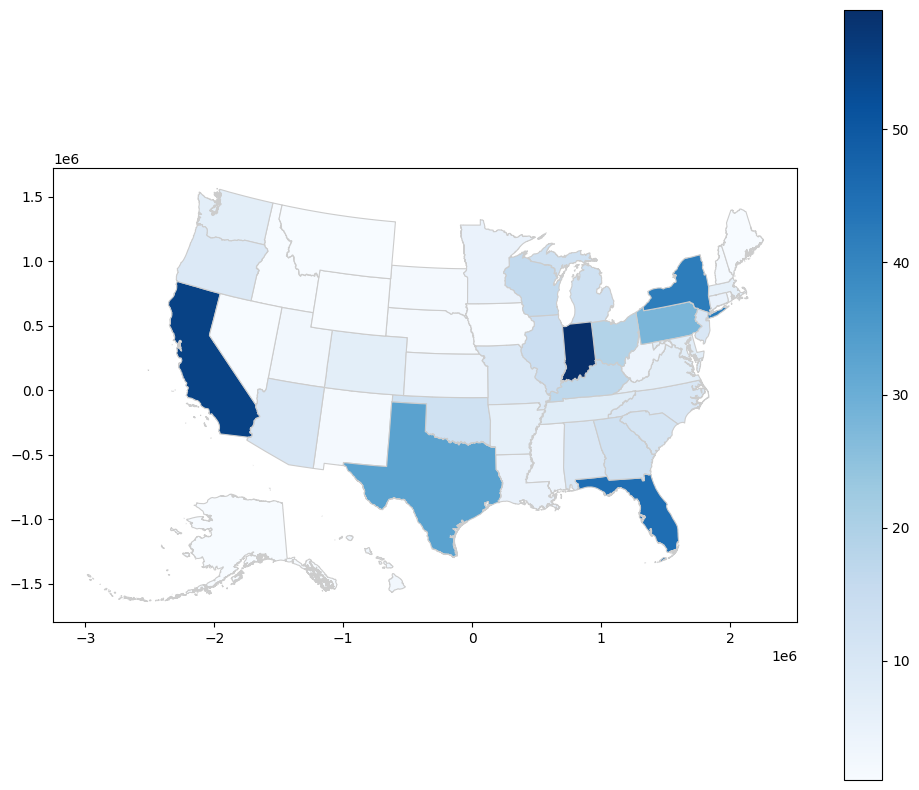

In [12]:
#Plot the GeoDataFrame 'merged' with states colored according to the 'Count' column
#linewidth sets the boundary line width, edgecolor sets boundaries color
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.show()

In [13]:
print(len(merged))
merged = merged.dropna()
print(len(merged))

51
48


In [14]:
merged['Count'] = merged['Count'].astype('int')

In [15]:
%matplotlib inline

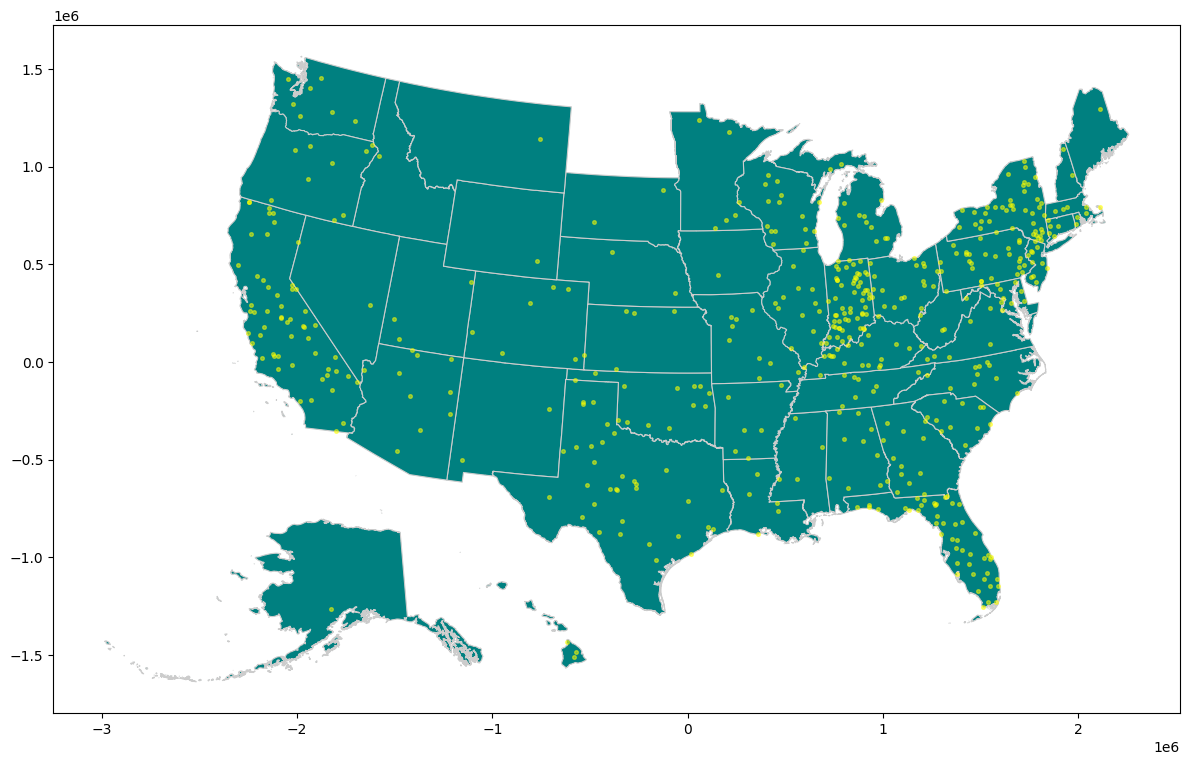

In [16]:
# Plot the map with states colored according to the count
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged.plot(linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, color = 'teal')

# Plot markers for each occurrence
# Iterate over each row in the GeoDataFrame 'merged'
for idx, row in merged.iterrows():
    count = row['Count']
    state_geometry = row.geometry
    
    # Generate random points within the state's geometry
    random_points = []
    while len(random_points) < count:
        # Generate random x and y coordinates within the bounding box of the state's geometry
        x = np.random.uniform(state_geometry.bounds[0], state_geometry.bounds[2])
        y = np.random.uniform(state_geometry.bounds[1], state_geometry.bounds[3])
        # Create a point with the generated coordinates
        point = Point(x, y)
        # Check if the point is within the state's geometry and add the point to the list of random points
        if point.within(state_geometry):
            random_points.append(point)
    
    # Plot each generated point as a scatter plot on the axis
    for point in random_points:
        ax.scatter(point.x, point.y, s=7, color='yellow', alpha=0.5)
        
# Adjust the layout and display the plot
plt.tight_layout()
plt.show()